In [1]:
# for Phase_I_II data

import sys
util_path = "/Users/kimd999/Dropbox/script/python/srpAnalytics/analysis/latest/3_bmd_feasibility_BMD/common/util"
sys.path.insert(0, util_path)

import numpy as np
import pandas as pd
import os, shutil, sys, time
from scipy import stats
from matplotlib import pyplot as plt

import generate_dose_response_newest_no_avg as gdr

import BMD_BMDL_estimation as bmdest
import Plot_Save as ps
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
starting_dir = os.getcwd()
print (starting_dir)

/Users/kimd999/Dropbox/script/python/srpAnalytics/analysis/latest/3_bmd_feasibility_BMD/Phase_I_II


In [3]:
complete_file_path = '/Users/kimd999/research/projects/toxicity/per_each_data/Phase_I_II/input/wide/344_zf_morphology_data_phase_1_and_2_-_2020JUNE25_wide_DNC_0.csv'

morphological_data = pd.read_csv(complete_file_path, header = 0)
pd.set_option('display.max_columns', None)
display(morphological_data.head())
display(morphological_data.columns)
display(np.unique(morphological_data.well))

,chemical.id,plate.id,well,chemical_plate_well,conc,AXIS,BRAI,CFIN,CIRC,DNC_,DP24,EYE_,JAW_,MO24,MORT,NC24,NC__,OTIC,PE__,PFIN,PIG_,SM24,SNOU,SOMI,SWIM,TRUN,TR__,YSE_
0,53,9289,A01,53_9289_A01,50.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,53,9289,A02,53_9289_A02,35.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,53,9289,A03,53_9289_A03,11.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,53,9289,A04,53_9289_A04,5.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,53,9289,A05,53_9289_A05,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Index(['chemical.id', 'plate.id', 'well', 'chemical_plate_well', 'conc',
       'AXIS', 'BRAI', 'CFIN', 'CIRC', 'DNC_', 'DP24', 'EYE_', 'JAW_', 'MO24',
       'MORT', 'NC24', 'NC__', 'OTIC', 'PE__', 'PFIN', 'PIG_', 'SM24', 'SNOU',
       'SOMI', 'SWIM', 'TRUN', 'TR__', 'YSE_'],
      dtype='object')

array(['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09',
       'A10', 'A11', 'A12', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06',
       'B07', 'B08', 'B09', 'B10', 'B11', 'B12', 'C01', 'C02', 'C03',
       'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12',
       'D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09',
       'D10', 'D11', 'D12', 'E01', 'E02', 'E03', 'E04', 'E05', 'E06',
       'E07', 'E08', 'E09', 'E10', 'E11', 'E12', 'F01', 'F02', 'F03',
       'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12',
       'G01', 'G02', 'G03', 'G04', 'G05', 'G06', 'G07', 'G08', 'G09',
       'G10', 'G11', 'G12', 'H01', 'H02', 'H03', 'H04', 'H05', 'H06',
       'H07', 'H08', 'H09', 'H10', 'H11', 'H12'], dtype=object)

In [4]:
test_data_sim = 0
if(test_data_sim == 0):
    # Add aggregate endpoints
    # 1. Any effect at 24hrs (combination of MO24, DP24 and SM24) >> 'ANY24'
    # 2. Any effect within 5 days (combination of all measurements at both time points)
    # 3. Total mortality (MO24 + MORT) >> 'TOT_MORT'
    # 4. Any effect except mortality (#2 minus MO24 and MORT) >> 'ANY_MORT'
    # Add new endpoints
    # BRAIN	OTIC	PFIN >> 'BRN_'
    # EYE	SNOUT	JAW >> 'CRAN'
    # YSE	PE >> 'EDEM'
    # TRUNK	CFIN >> 'LTRK'
    # CIRC	SWIM	SOMITE >> 'MUSC'
    # PIG_ >> 'SKIN'
    # TR_ >> 'TCHR'
    morphological_data['ANY24'] = morphological_data[['MO24','DP24','SM24','NC24']].sum(axis=1,skipna=True,min_count=1)
    morphological_data['ANY120'] = morphological_data[['MORT', 'YSE_', 'AXIS', 'EYE_', 'SNOU', 'JAW_', 'OTIC', \
                                                       'PE__', 'BRAI', 'SOMI', 'PFIN', 'CFIN', 'PIG_', 'CIRC', \
                                                       'TRUN', 'SWIM', 'NC__', 'TR__', 'ANY24']].sum(axis=1,skipna=True,min_count=1)
    morphological_data['TOT_MORT'] = morphological_data[['MO24','MORT']].sum(axis=1,skipna=True,min_count=1)
    morphological_data['ALL_BUT_MORT'] = morphological_data[['DP24','SM24','NC24', 'YSE_', 'AXIS', 'EYE_', 'SNOU', 'JAW_', 'OTIC', \
                                                       'PE__', 'BRAI', 'SOMI', 'PFIN', 'CFIN', 'PIG_', 'CIRC','TRUN', 'SWIM', 'NC__', \
                                                       'TR__']].sum(axis=1,skipna=True,min_count=1)
    morphological_data['BRN_'] = morphological_data[['BRAI','OTIC','PFIN']].sum(axis=1,skipna=True,min_count=1)
    morphological_data['CRAN'] = morphological_data[['EYE_', 'SNOU', 'JAW_']].sum(axis=1,skipna=True,min_count=1)
    morphological_data['EDEM'] = morphological_data[['YSE_','PE__']].sum(axis=1,skipna=True,min_count=1)
    morphological_data['LTRK'] = morphological_data[['TRUN','CFIN']].sum(axis=1,skipna=True,min_count=1)
    morphological_data['MUSC'] = morphological_data[['CIRC','SWIM','SOMI']].sum(axis=1,skipna=True,min_count=1)
    morphological_data['SKIN'] = morphological_data[['PIG_']]
    morphological_data['TCHR'] = morphological_data[['TR__']]

In [5]:
display(morphological_data.head())

,chemical.id,plate.id,well,chemical_plate_well,conc,AXIS,BRAI,CFIN,CIRC,DNC_,DP24,EYE_,JAW_,MO24,MORT,NC24,NC__,OTIC,PE__,PFIN,PIG_,SM24,SNOU,SOMI,SWIM,TRUN,TR__,YSE_,ANY24,ANY120,TOT_MORT,ALL_BUT_MORT,BRN_,CRAN,EDEM,LTRK,MUSC,SKIN,TCHR
0,53,9289,A01,53_9289_A01,50.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,53,9289,A02,53_9289_A02,35.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,53,9289,A03,53_9289_A03,11.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,53,9289,A04,53_9289_A04,5.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,5.0,0.0,5.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0
4,53,9289,A05,53_9289_A05,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
if (os.path.isdir("output") == True):
    shutil.rmtree("output")
os.mkdir("output")

output_folder = os.path.join(starting_dir, "output")
os.chdir(output_folder)

if (os.path.isdir("report") == False):
    os.mkdir("report")
    
morphological_data_filename = os.path.join("report", 'morphological_data_after_merging_endpoints.csv')
morphological_data.to_csv(morphological_data_filename, index=False)

In [7]:
erased_since_gt_0p5_1_neg_filename = os.path.join("report", 'erased_since_gt_0p5_1_neg.csv')
erased_since_gt_0p5_1_neg_file = open(erased_since_gt_0p5_1_neg_filename, "w")
write_this="chemical_id,plate_id,end_point\n"
erased_since_gt_0p5_1_neg_file.write(write_this)
erased_since_gt_0p5_1_neg_file.close()


kept_since_lt_0p5_1_neg_filename = os.path.join("report", 'kept_since_lt_0p5_1_neg.csv')
kept_since_lt_0p5_1_neg_file = open(kept_since_lt_0p5_1_neg_filename, "w")
write_this="chemical_id,plate_id,end_point\n"
kept_since_lt_0p5_1_neg_file.write(write_this)
kept_since_lt_0p5_1_neg_file.close()



erased_since_lt_0p25_filled_filename = os.path.join("report", 'erased_since_lt_0p25_filled.csv')
erased_since_lt_0p25_filled_file = open(erased_since_lt_0p25_filled_filename, "w")
write_this="chemical_id,end_point,dose\n"
erased_since_lt_0p25_filled_file.write(write_this)
erased_since_lt_0p25_filled_file.close()


kept_since_gt_0p25_filled_filename = os.path.join("report", 'kept_since_gt_0p25_filled.csv')
kept_since_gt_0p25_filled_file = open(kept_since_gt_0p25_filled_filename, "w")
write_this="chemical_id,end_point,dose\n"
kept_since_gt_0p25_filled_file.write(write_this)
kept_since_gt_0p25_filled_file.close()

In [8]:
start_time = time.time()

bmd_feasibility_flag_filename = os.path.join("report", 'bmd_feasibility_flag.csv')
bmd_feasibility_flag_file_out = open(bmd_feasibility_flag_filename, "w")

write_this = "bmd_feasibility_flag\n"
bmd_feasibility_flag_file_out.write(write_this)

# full -> 18 (without DNC)
#end_points = ['ANY24','ANY120','AXIS','ALL_BUT_MORT','BRN_','CRAN','DP24','EDEM','LTRK','MO24','MORT','MUSC','NC__','NC24', 'SKIN','SM24','TCHR','TOT_MORT']
end_points = ['TCHR']

# all 342 chemicals
#for chemical_id in np.unique(morphological_data['chemical.id']):
    
for chemical_id in [62]:
    print("chemical_id:" + str(chemical_id))

    for end_point in end_points:
        os.chdir(output_folder)
        # subset original dataframe for a user-specified chemical and end_point pair
        morphological_data_end_point_chemical_id = morphological_data.loc[morphological_data['chemical.id'] == chemical_id,['chemical.id', 'conc', 'plate.id', 'well', end_point]]
        
        # Binarize end-point hits (Values > 1 are forced to 1)
        end_point_hits = morphological_data_end_point_chemical_id[end_point]
        end_point_hits.loc[end_point_hits > 0] = 1
                  
        dose_response = gdr.gen_dose_response(morphological_data_end_point_chemical_id, end_point)
        
        bmd_feasibility_flag = gdr.BMD_feasibility_analysis(dose_response)
        bmd_feasibility_flag_file_out.write(str(bmd_feasibility_flag)+"\n")

        print ("dose_response:" + str(dose_response))        
        '''dose  num_affect  frac_affect  num_embryos  tot_wells
        0   0.0         0.0     0.000000         26.0       32.0
        1   0.1         1.0     0.032258         31.0       32.0
        2   0.5         1.0     0.062500         16.0       32.0
        '''
        test_dose_response = gdr.reformat_dose_response(dose_response)
        print ("test_dose_response:" + str(test_dose_response))
        '''dose  num_affected  total_num
        0   0.0           0.0       26.0
        1   0.1           1.0       31.0
        2   0.5           1.0       16.0
        '''
        bmd_feasibility_flag_folder = "bmd_feasibility_" + str(bmd_feasibility_flag)
        if (os.path.isdir(str(bmd_feasibility_flag_folder)) == False):
            os.mkdir(str(bmd_feasibility_flag_folder))
        os.chdir(str(bmd_feasibility_flag_folder))

        if(bmd_feasibility_flag in [0, 1]):
            # No BMD analysis required. Generate report and exit
            ps.save_results_poor_data_or_no_convergence(test_dose_response, bmd_feasibility_flag, str(chemical_id), end_point, None)
        else:
            # Fit dose response models
            model_predictions = bmdest.analyze_dose_response_data(test_dose_response)
            # Select best model
            selected_model_params = bmdest.select_model(model_predictions)
            # Check if unique model is found
            unique_model_flag = selected_model_params['no_unique_model_found_flag']
            if(unique_model_flag == 0):
                # Generate report
                print(test_dose_response.dose[-1:])
                ps.save_results_good_data_unique_model(test_dose_response, bmd_feasibility_flag, model_predictions, selected_model_params, str(chemical_id), end_point)
            else:
                bmd_analysis_flag = selected_model_params['model_select_flag']
                if(bmd_analysis_flag == 1):
                    ps.save_results_poor_data_or_no_convergence(test_dose_response, bmd_feasibility_flag, str(chemical_id), end_point, selected_model_params)
                else:
                    ps.save_results_good_data_nounique_model(test_dose_response, bmd_feasibility_flag, model_predictions, selected_model_params, str(chemical_id), end_point)
bmd_feasibility_flag_file_out.close()
end_time = time.time()
time_took = str(round((end_time-start_time), 1)) + " seconds"
print ("Done, it took:"+str(time_took)) 
# for all combinations of 342 chemicals and 18 endpoints, 4 minutes took for bmd_feasibility only
# for all combinations of 342 chemicals and 18 endpoints, 104~165 minutes took for bmd_feasibility and bmd report

os.chdir(output_folder)
time_filename = os.path.join("report", 'running_time.txt')
f_time = open(time_filename, 'w')
f_time.write(str(time_took))
f_time.close()

chemical_id:62
data_ep_cid:
      chemical.id  conc  plate.id well  TCHR
1344           62  5.00     12839  A01   NaN
1345           62  3.56     12839  A02   NaN
1346           62  1.12     12839  A03   NaN
1347           62  0.50     12839  A04   NaN
1348           62  0.10     12839  A05   0.0
...           ...   ...       ...  ...   ...
1531           62  3.56     12841  H08   NaN
1532           62  1.12     12841  H09   NaN
1533           62  0.50     12841  H10   0.0
1534           62  0.10     12841  H11   0.0
1535           62  0.00     12841  H12   0.0

[192 rows x 5 columns]
dose_response:   dose  num_affect  frac_affect  num_embryos  tot_wells
0   0.0         0.0     0.000000         26.0       32.0
1   0.1         1.0     0.032258         31.0       32.0
2   0.5         1.0     0.062500         16.0       32.0
test_dose_response:   dose  num_affected  total_num
0   0.0           0.0       26.0
1   0.1           1.0       31.0
2   0.5           1.0       16.0
logistic
start_

In [9]:
#print (morphological_data_end_point_chemical_id)
np.asarray(morphological_data_end_point_chemical_id['plate.id'])

array([12839, 12839, 12839, 12839, 12839, 12839, 12839, 12839, 12839,
       12839, 12839, 12839, 12839, 12839, 12839, 12839, 12839, 12839,
       12839, 12839, 12839, 12839, 12839, 12839, 12839, 12839, 12839,
       12839, 12839, 12839, 12839, 12839, 12839, 12839, 12839, 12839,
       12839, 12839, 12839, 12839, 12839, 12839, 12839, 12839, 12839,
       12839, 12839, 12839, 12839, 12839, 12839, 12839, 12839, 12839,
       12839, 12839, 12839, 12839, 12839, 12839, 12839, 12839, 12839,
       12839, 12839, 12839, 12839, 12839, 12839, 12839, 12839, 12839,
       12839, 12839, 12839, 12839, 12839, 12839, 12839, 12839, 12839,
       12839, 12839, 12839, 12839, 12839, 12839, 12839, 12839, 12839,
       12839, 12839, 12839, 12839, 12839, 12839, 12841, 12841, 12841,
       12841, 12841, 12841, 12841, 12841, 12841, 12841, 12841, 12841,
       12841, 12841, 12841, 12841, 12841, 12841, 12841, 12841, 12841,
       12841, 12841, 12841, 12841, 12841, 12841, 12841, 12841, 12841,
       12841, 12841,

In [10]:
#[np.unique(morphological_data_end_point_chemical_id['chemical.id'].values()),1]

bmd_feasibility_flag_filename:output/report/bmd_feasibility_flag.csv


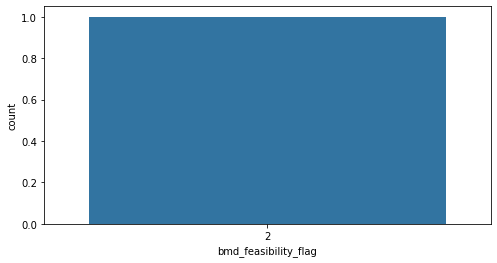

In [11]:
os.chdir(starting_dir)

#bmd_feasibility_flag_filename="/Users/kimd999/research/projects/toxicity/result/old_Phase_I_II/newest_criteria_no_avg/report/bmd_feasibility_flag.csv"
bmd_feasibility_flag_filename = os.path.join("output", "report", 'bmd_feasibility_flag.csv')
print ("bmd_feasibility_flag_filename:"+str(bmd_feasibility_flag_filename))
bmd_feasibility_flag_data = pd.read_csv(bmd_feasibility_flag_filename, index_col=None)
#display(bmd_feasibility_flag_data.head())
ds = pd.Series({"Column": bmd_feasibility_flag_data["bmd_feasibility_flag"]})
plt.figure(figsize=(8,4))
sns.countplot(x="Column", data=ds)
plt.show()

In [12]:
'''os.chdir(starting_dir)

sns.set_theme(style="whitegrid")
print ("array_filename:"+str(array_filename))
array_report_data = pd.read_csv(array_filename, index_col=None)
display(array_report_data.head())
#ax = sns.barplot(x="end_point", y="len_test_dose_response", data=array_report_data)

ds = pd.Series({"Column": array_report_data["len_test_dose_response"]})
plt.figure(figsize=(8,4))
plt.xlabel("leng")
sns.countplot(x="Column", data=ds)
plt.show()
print ("done")'''

'os.chdir(starting_dir)\n\nsns.set_theme(style="whitegrid")\nprint ("array_filename:"+str(array_filename))\narray_report_data = pd.read_csv(array_filename, index_col=None)\ndisplay(array_report_data.head())\n#ax = sns.barplot(x="end_point", y="len_test_dose_response", data=array_report_data)\n\nds = pd.Series({"Column": array_report_data["len_test_dose_response"]})\nplt.figure(figsize=(8,4))\nplt.xlabel("leng")\nsns.countplot(x="Column", data=ds)\nplt.show()\nprint ("done")'

In [13]:
test_dose_response.dose

0    0.0
1    0.1
2    0.5
Name: dose, dtype: float64

In [14]:
#test_dose_response.dose.iloc[0]+test_dose_response.dose.iloc[1]

In [15]:
dose_response['num_affect']/dose_response['num_embryos']

0    0.000000
1    0.032258
2    0.062500
dtype: float64